In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
import time
from matplotlib import rcParams
sns.set()
figsize=(500, 100)
plt.style.use("ggplot")
rcParams["figure.figsize"] = [12, 9]
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15

import math
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv


In [68]:
df=pd.read_csv('../input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv' )
df['Date']=pd.to_datetime(df['Date'])
df.set_index(df['Date'],inplace=True)
del df['Date']
print("\n\n\n",df.head())




                    High          Low         Open        Close        Volume  \
Date                                                                           
2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088  3.587980e+09   
2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893  3.884930e+09   
2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107  1.466840e+09   

              Adj Close  
Date                     
2015-11-23  2086.590088  
2015-11-24  2089.139893  
2015-11-25  2088.870117  
2015-11-26  2088.870117  
2015-11-27  2090.110107  


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-11-23 to 2020-11-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1825 non-null   float64
 1   Low        1825 non-null   float64
 2   Open       1825 non-null   float64
 3   Close      1825 non-null   float64
 4   Volume     1825 non-null   float64
 5   Adj Close  1825 non-null   float64
dtypes: float64(6)
memory usage: 99.8 KB


# **Data Exploration**

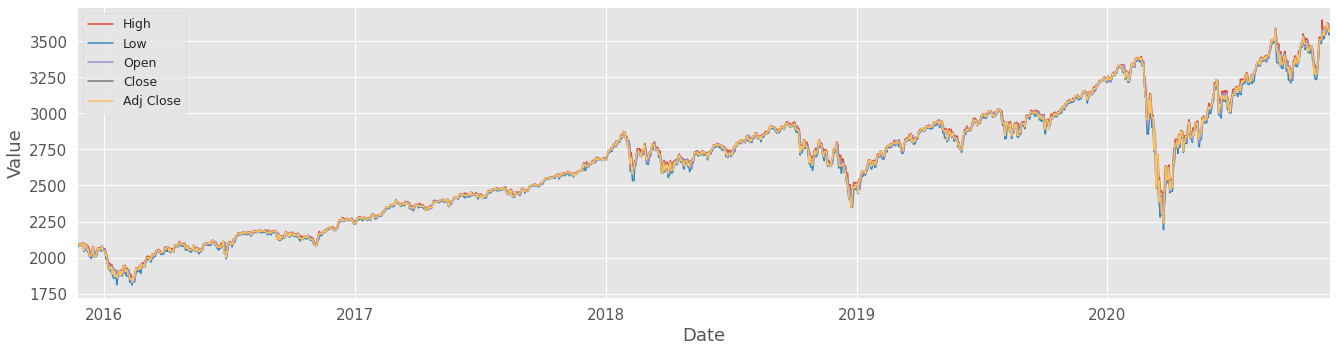

In [70]:
#Trend
df[['High','Low','Open','Close','Adj Close']].plot(figsize=(20, 5))
plt.legend(fontsize="small")
plt.xlabel("Date")
plt.ylabel("Value");

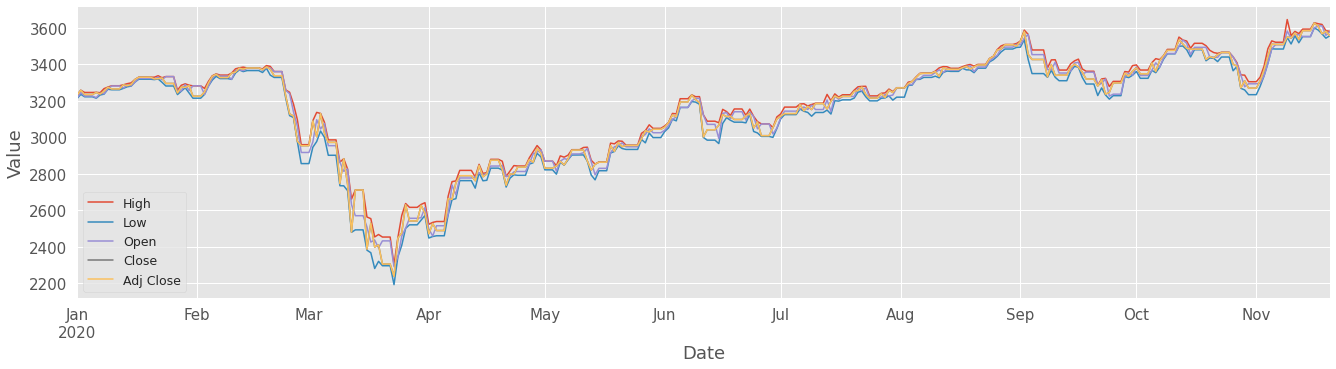

In [71]:
#2020 Trend
#Trend
df.loc['2020-01-01':][['High','Low','Open','Close','Adj Close']].plot(figsize=(20, 5))
plt.legend(fontsize="small")
plt.xlabel("Date")
plt.ylabel("Value");

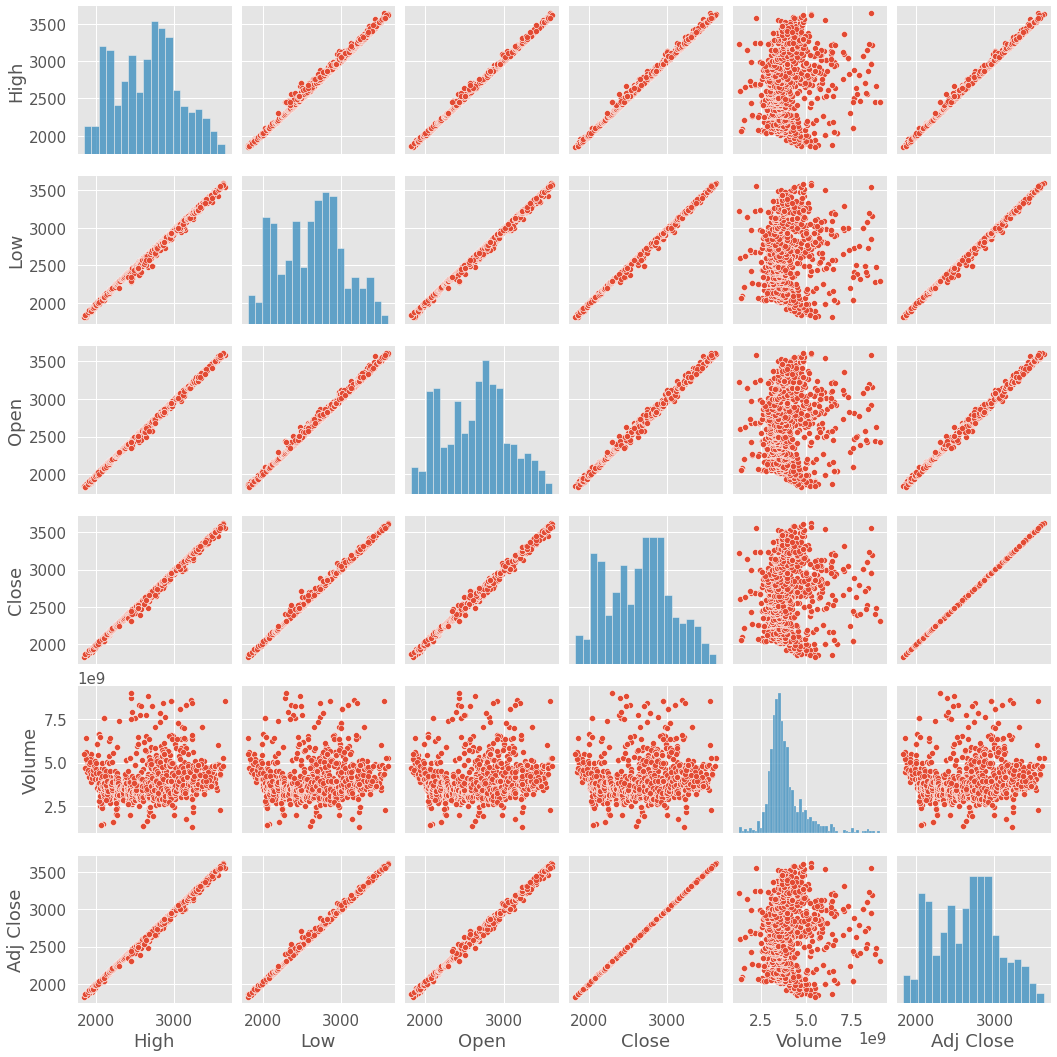

In [72]:
import seaborn as sns
sns.pairplot(df)

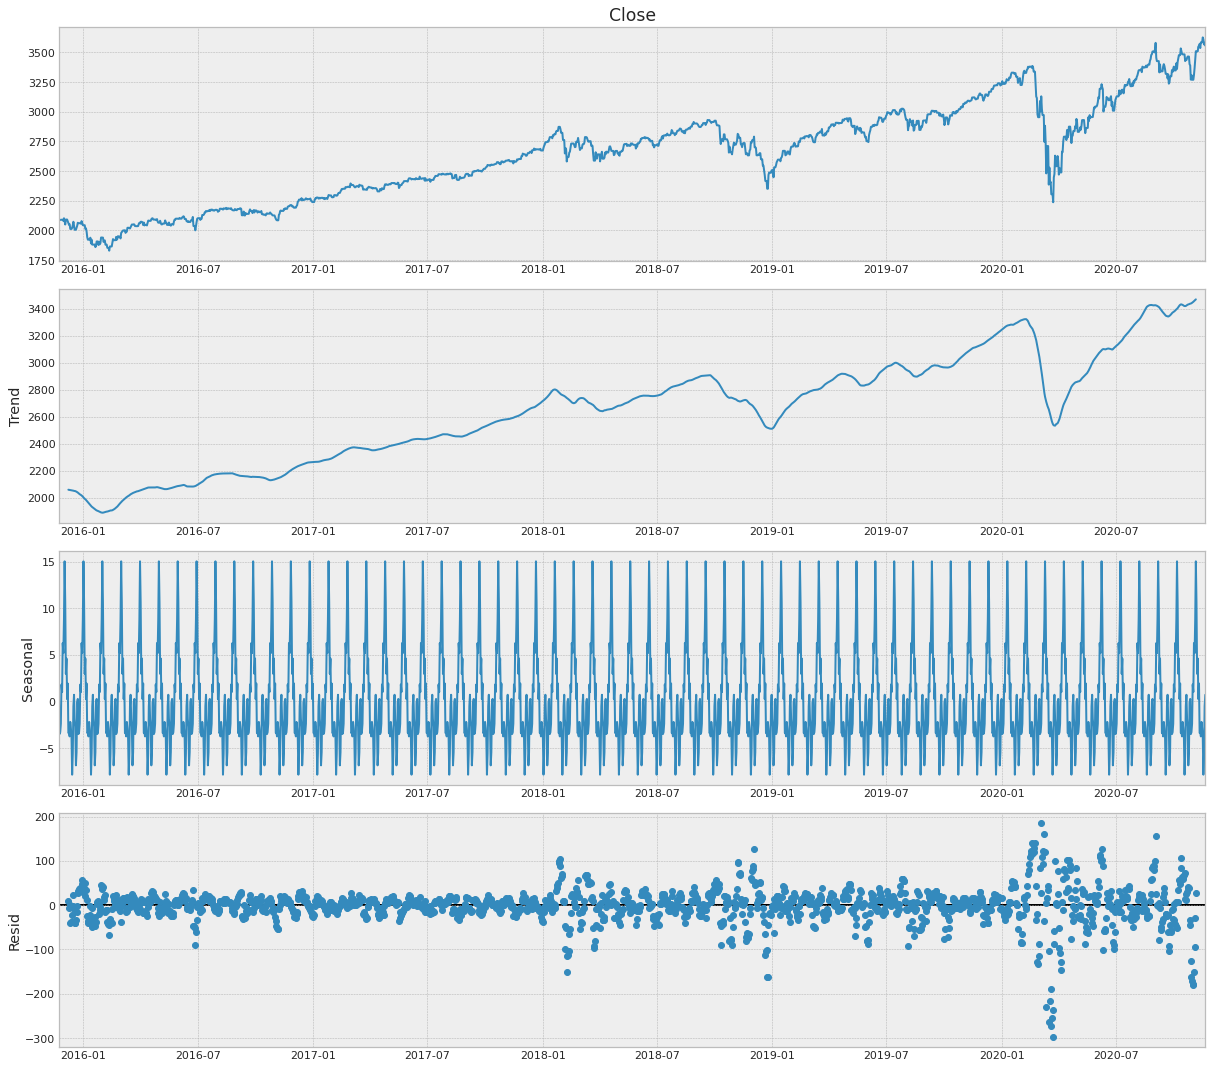

In [73]:
from pylab import rcParams
rcParams['figure.figsize'] = 17,15
rcParams['lines.color'] = 'teal'


result = seasonal_decompose(df['Close'], model='additive', period=30)
sns.set()

plt.style.use('bmh')
result.plot()

plt.show()

# **Forecasting using LSTM**

## **Modeling**

In [74]:
TRAIN_PERCENT = 0.8
time_series=df['Close']
VERBOSE = True
seq_lstm_model=None

def get_seq_train_test(time_series, scaling=True,train_size=0.8):
    scaler = None
    if scaling:
        scaler = MinMaxScaler(feature_range=(0, 1))
        time_series = np.array(time_series).reshape(-1,1)
        scaled_stock_series = scaler.fit_transform(time_series)
    else:
        scaled_stock_series = time_series
        
    train_size = int(len(scaled_stock_series) * train_size)
    train = scaled_stock_series[0:train_size]
    test = scaled_stock_series[train_size:len(scaled_stock_series)]
    return train,test,scaler 

def get_seq_model(hidden_units=7,input_shape=(1,1),verbose=False):
    model = Sequential()
    model.add(LSTM(input_shape=input_shape,units = hidden_units,return_sequences=True ))
    model.add(TimeDistributed(Dense(1)))
    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    if verbose:
        print("> Compilation Time : ", time.time() - start)
        print(model.summary())
    return model

train,test,scaler = get_seq_train_test(time_series,scaling=True,train_size=TRAIN_PERCENT)
train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))
train_x = train[:,:-1,:]
train_y = train[:,1:,:]
test_x = test[:,:-1,:]
test_y = test[:,1:,:]
print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

#Fitting Model
seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),verbose=VERBOSE)   
seq_lstm_model.fit(train_x, train_y, epochs=150, batch_size=8,verbose=1)
print("Model Fit Complete")

train_x shape=(1, 1459, 1)
train_y shape=(1, 1459, 1)
test_x shape=(1, 364, 1)
test_y shape=(1, 364, 1)
> Compilation Time :  0.008644819259643555
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1459, 7)           252       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1459, 1)           8         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.0511
Epoch 2/150
1/1 [==============================] - 0s 492ms/step - loss: 0.0476
Epoch 3/150
1/1 [==============================] - 1s 503ms/step - loss: 0.0443
Epoch 4/150
1/1 [==============================] - 0s 400ms/step - loss: 0.0410
Epoch 5/150
1/1 [==============================] 

## **Evaluation & Forecast**

Train Score: 0.02 RMSE
Train Score: inf MAPE
Test Score: 0.12 RMSE
Test Score: 13.45 MAPE


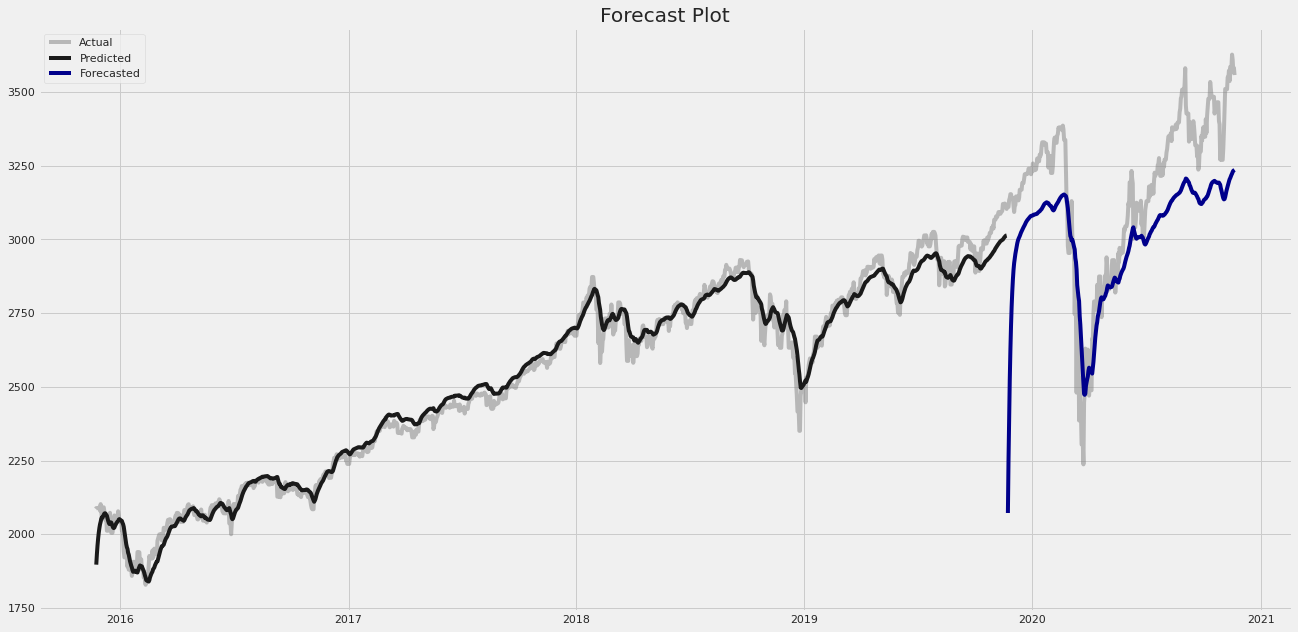

In [75]:
#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

sp_close_series=df['Close'].copy()
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train Score: %.2f MAPE' % (MAPE(train_y[0], trainPredict[0])))
#Padding
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')
testPredict = seq_lstm_model.predict(testPredict)
# evaluate performances
testScore = math.sqrt(mean_squared_error(test_y[0], testPredict[0][:test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % (MAPE(test_y[0],testPredict[0][:test_x.shape[1]])))

trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))#trainPredict.shape[1]))
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))#testPredict.shape[1]))

#Plotting Results
train_size = len(trainPredict)+1
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.plot(sp_close_series.index,sp_close_series.values,c='grey',alpha=0.5,label='Actual')
plt.plot(sp_close_series.index[1:train_size],trainPredict,label='Predicted', c='k')
plt.plot(sp_close_series.index[train_size+1:],testPredict[:test_x.shape[1]],label='Forecasted', c='darkblue', linewidth=4)
plt.title('Forecast Plot')
plt.legend()
plt.show()